In [3]:
#!pip install ultralytics
#!git clone LearnItAnyway/YOLO_LLaMaVisNav

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/75/ec/9f9f64358fe1a93bf4bb64903f379f498fdc145d5a7e875775cd26b8ed89/ultralytics-8.0.142-py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python>=4.6.0 from https://files.pythonhosted.org/packages/34/7c/8a5043f362b0a55f07812a0db3f86092cdbd0fe41b933d7bc6fce3ab6c15/opencv_python-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.0/608.0 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 8.8 MB/s eta 0:00:0000:01:00:01


In [5]:
import torch

import io
from PIL import Image
import json
from llava import LlavaLlamaForCausalLM
from transformers import LlamaForCausalLM, AutoTokenizer
from transformers import CLIPImageProcessor
from ultralytics import YOLO
import pandas as pd

class_name_to_id_mapping = {'kiosk': 0, 'person': 1, 'motorcycle': 2,
    'potted_plant': 3, 'movable_signage': 4, 'truck': 5, 'stop': 6,
    'cat': 7, 'bollard': 8, 'traffic_sign': 9, 'tree_trunk': 10, 'car': 11,
    'wheelchair': 12, 'fire_hydrant': 13, 'bicycle': 14, 'chair': 15,
    'traffic_light': 16, 'pole': 17, 'parking_meter': 18, 'dog': 19,
    'table': 20, 'scooter': 21, 'bench': 22, 'barricade': 23,
    'stroller': 24, 'bus': 25, 'carrier': 26}
class_ids = list(class_name_to_id_mapping.keys())

## Load Model
llm = './YOLO_LLaMa_VisNav'
device='cuda'
yolo_model = YOLO('YOLO_LLaMa_VisNav/yolo.pt')

def image_to_table(imgs):
    output = yolo_model.predict(imgs)[0]
    xyxy = output.boxes.xyxy.cpu().numpy()
    y_, x_ = output.orig_shape

    xyxy[:, 0] = xyxy[:, 0]/x_
    xyxy[:, 1] = xyxy[:, 1]/y_
    xyxy[:, 2] = xyxy[:, 2]/x_
    xyxy[:, 3] = xyxy[:, 3]/y_

    xyxy = xyxy.round(3)

    cc = pd.DataFrame.from_dict({'class':[class_ids[a] for a in output.boxes.cls.int().cpu().numpy()],
        'xmin': xyxy[:, 0], 'ymin': xyxy[:, 1],
        'xmax': xyxy[:, 2], 'ymax': xyxy[:, 3],
        'size': (((xyxy[:, 2]-xyxy[:, 0])*(xyxy[:, 3]-xyxy[:, 1]))**0.5).round(2)})
    dd = cc.iloc[cc['size'].argsort().values][['class', 'xmin', 'ymin', 'xmax', 'ymax', 'size']]
    str_ = '<table start>\n'
    for i in range(len(dd)):
        str_ += f"{str(dd.iloc[i].values)}\n"
    str_ += '<table end>'
    return str_


tokenizer = AutoTokenizer.from_pretrained(llm, use_fast=False)
model = LlamaForCausalLM.from_pretrained(llm).half().to(device)


You are using a model of type llava to instantiate a model of type llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./YOLO_LLaMa_VisNav were not used when initializing LlamaForCausalLM: ['model.mm_projector.weight', 'model.mm_projector.bias']
- This IS expected if you are initializing LlamaForCausalLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaForCausalLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
def get_response(data, image=None, image_table=None):
    assert image!=None or image_table!=None
    if image_table==None:
        image_table=image_to_table(image)
    chats, roles = data['chats'], data['roles']
    if chats[0].find('<image>') == -1:
        chats[0] = '<image>' + chats[0]
    data_ = []
    image_flag = False
    for c_, r_ in zip(chats, roles):
        data_.append({'role': r_, 'content': f'{c_}'})

    str_ = ''
    for d_ in data_:
        r_, c_ = d_['role'], d_['content']
        if r_ == 'user':
            str_ += f"### USER: {c_}\n"
        else:
            str_ += f"### ASSISTANT: {c_}\n"
    str_ += "### ASSISTANT: "
    if str_.find('<image>') != -1:
        left_, right_ = str_.split('<image>')[:-1], str_.split('<image>')[-1]
        left_ = ''.join(left_)
        str_ = f"{left_}{image_table}{right_}"
    input_ids = tokenizer.encode(str_, add_special_tokens=False, return_tensors='pt').to(device)
    output = model.generate(input_ids, max_new_tokens=64)
    text = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    text = text.split('### ASSISTANT: ')[-1]
    text = text.replace('\n\n', '\n')
    if text[-1]=='\n':
        text = text[:-1]
    return text

In [30]:
image = Image.open('test_image.jpg')
image_table = image_to_table(image)


0: 384x640 10 tree_trunks, 1 car, 5.2ms
Speed: 2.5ms preprocess, 5.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


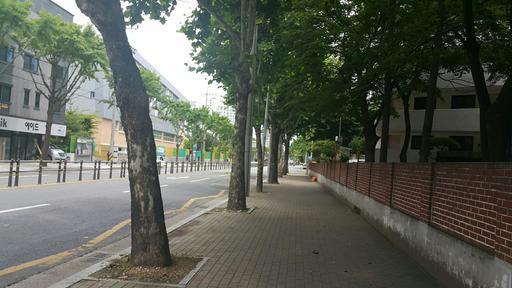

In [31]:
image

In [32]:
print(image_table)

<table start>
['tree_trunk' 0.553 0.481 0.565 0.606 0.04]
['tree_trunk' 0.549 0.478 0.565 0.607 0.05]
['tree_trunk' 0.524 0.469 0.545 0.638 0.06]
['tree_trunk' 0.499 0.436 0.515 0.668 0.06]
['tree_trunk' 0.082 0.389 0.105 0.565 0.06]
['car' 0.054 0.507 0.132 0.565 0.07]
['tree_trunk' 0.78 0.339 0.804 0.622 0.08]
['tree_trunk' 0.738 0.31 0.765 0.638 0.09]
['tree_trunk' 0.817 0.233 0.856 0.679 0.13]
['tree_trunk' 0.442 0.326 0.489 0.731 0.14]
['tree_trunk' 0.201 0.108 0.336 0.931 0.33]
<table end>


In [33]:
data = {'chats':[], 'roles':[]}
while True:
    user_input = input("\nUSER: ")
    data['chats'].append(user_input)
    data['roles'].append('user')
    if user_input.lower() == "quit":
        print("ASSISTANT: Goodbye!")
        break
    else:
        response = get_response(data, image_table=image_table)
        data['chats'].append(response)
        data['roles'].append('assistant')
        print(f"ASSISTANT: {response}")


USER:  is there any obstacles?


ASSISTANT:  Of course! There are several tree trunks scattered throughout the image, some of which are partially occluded. Additionally, there is a car present in the image, although it is partially hidden by other objects.



USER:  Tree is on the left or the right side?


ASSISTANT:  The tree trunks are positioned on both the left and right sides of the image.



USER:  How many trees are there?


ASSISTANT:  The number of tree trunks in the image is not specified, but it appears to be at least 10.



USER:  Is there any car? which direction should I pay attention most?


ASSISTANT:  Yes, there is a car present in the image, although it is partially hidden by other objects. It is important to be cautious and aware of its presence while navigating through the image.



USER:  Front, left, or right. Which direction should I go?


ASSISTANT:  It is difficult to determine the exact direction from the given information. However, it is important to be aware of the tree trunks and the car, as well as any other obstacles or objects that may be present in the image. It is important to navigate safely and cautiously, considering all the information available.



USER:  quit


ASSISTANT: Goodbye!
